In [5]:
import os
import re
import pickle

import numpy as np
import matplotlib.pyplot as plt
import uproot3
from coffea import hist

from samples import signal_samples
from helpers import files_from_dir, files_from_dirs
#from exp_limits import exp_limits_mu

from HNLAnalysis import HNLAnalysis
from ROOT import TFile, TH1D, THStack, kRed, kBlue


In [6]:
# Read in reults from coffea run
#tag = 'bck_WZ_ZZ_TT_tighter_sel_electron'
tag = '220425_test_newbck_1'

with open(f'result_{tag}.pkl', 'rb') as f:
    result = pickle.load(f)
with open (f'counter_{tag}.pkl', 'rb') as f:
    event_counter = pickle.load(f)


In [7]:
# Lumi and cross sections for plotting
xsecs = { # pb

    #'ZZ':0.0349,
    #'ZZ_old':0.0349,
    'WZ':5.213,
    'WZ_old':5.213,
}

lumi = 60000. # pb-1
plot_scale = {

    #'ZZ':1.,
    #'ZZ_old':1.,
    'WZ':1.,
    'WZ_old':1.,
}

event_counter['sumw']['Data'] = lumi

# A bit hacky treatment of same-sign, more elegant way well possible...
#for k, v in list(xsecs.items()):
#    if not 'HNL' in k:
#        xsecs[k+'SS'] = v
#for k, v in list(plot_scale.items()):
#    if not 'HNL' in k and not k+'SS' in plot_scale:
#        plot_scale[k+'SS'] = v
#for k, v in list(xsecs.items()):
#    if 'Data' in k:
#        event_counter['sumw'][k] = lumi
#    elif k.endswith('SS'):
#        event_counter['sumw'][k] = event_counter['sumw'][k[:-2]]
        

[<cppyy.gbl.TH1D object at 0x5631dd54bb60>, <cppyy.gbl.TH1D object at 0x5631dd54b5c0>]
   
[<cppyy.gbl.TH1D object at 0x5631dd57a1f0>, <cppyy.gbl.TH1D object at 0x5631dd579d90>]
   
[<cppyy.gbl.TH1D object at 0x5631dd96abf0>, <cppyy.gbl.TH1D object at 0x5631dd96b050>]
   
[<cppyy.gbl.TH1D object at 0x5631dd954580>, <cppyy.gbl.TH1D object at 0x5631dd9654d0>]
   
[<cppyy.gbl.TH1D object at 0x5631dd9663a0>, <cppyy.gbl.TH1D object at 0x5631dd961120>]
   
[<cppyy.gbl.TH1D object at 0x5631dd9733a0>, <cppyy.gbl.TH1D object at 0x5631dd961690>]
   
[<cppyy.gbl.TH1D object at 0x5631dd9689b0>, <cppyy.gbl.TH1D object at 0x5631dd968550>]
   
[<cppyy.gbl.TH1D object at 0x5631dd970860>, <cppyy.gbl.TH1D object at 0x5631dd9849a0>]
   


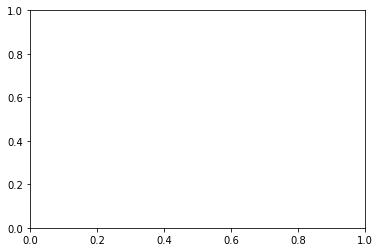

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [9]:

import re
import matplotlib as mpl
%matplotlib inline
from cycler import cycler
import warnings

not_hnl_data = re.compile('(?!HNL)(?!Data)^((?!SS).)*$')
hnl = re.compile('(HNL)')
# data = re.compile('(Data)((?!InvIso).)*$')
data = re.compile('^Data$|^DataSS$|^DataInvTimeSameBX$|^DataSSInvTimeSameBX$')

cols_bkg = ['#fde6f7', '#fafbc3', '#c4fbd6', '#b3e5f4']
cols_sig = ['black', '#386cb0','#f0027f','#bf5b17','#666666', '#7fc97f','#beaed4','#fdc086','#ffff99']
# cols_sig = ['red', 'green', 'blue','purple']
mpl.rcParams['axes.prop_cycle'] = cycler(color=cols_bkg)
colors_root = [kBlue,kRed]

for v in HNLAnalysis.get_var_axis_pairs():
   
    try:
        var = v[0]
        scales = {s:plot_scale[s]*lumi*xsecs[s]/event_counter['sumw'][s] if event_counter['sumw'][s] else 1. for s in xsecs.keys()}
        back_scales = {s:1./v for s, v in scales.items()}
        result[var].scale(scales, axis='ds')
        if not len(result[var].values()):
            continue
        plt.gca().set_prop_cycle(color=cols_sig)
        warnings.filterwarnings("ignore")
        
        #loop over all histogram of bck
        fout = uproot3.recreate('test_stack_'+ var+'.root' )
        for d in result[var].axis("ds").identifiers():
            new_h = result[var][d].integrate("ds")
            fout[str(d)] = hist.export1d(new_h)
           

        fout.close()
        
        fout = TFile('test_stack_'+ var+'.root', "UPDATE")
        list_histos = []
        for d in result[var].axis("ds").identifiers():
            list_histos.append(fout.Get(str(d)))
        print(list_histos)
        hs = THStack("hs","")
        i = 0
        for h in list_histos:
            h.SetFillColor(colors_root[i]);
            i = i+1
            hs.Add(h)
        hs.Draw()    
        hs.Write()     
            
            
            
        name_plot = tag +"_"+ var
        print('   ')
        result[var].scale(back_scales, axis='ds') #Alternatively make a deepcopy for each round of plotting?
        warnings.filterwarnings("default")
    except AssertionError:
        pass

